In [1]:
# !pip install -q --upgrade transformers diffusers ftfy

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

In [1]:
%matplotlib inline
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms as tfms
import PIL
import os
from base64 import b64encode
import torch.nn.functional as F

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [32]:
# Style and content loss functions

import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

cnn = models.vgg19(pretrained=True).features.to(torch_device).eval()
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(torch_device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

import torchvision.transforms as transforms

imsize = 512
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # resize image
    image = image.resize((imsize, imsize))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(torch_device, torch.float)

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(torch_device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(torch_device)

def get_style_scores(input_image, final_image_label_0, final_image_label_1):
    final_image_label_0.save('final_image_label_0.jpg')
    final_image_label_1.save('final_image_label_1.jpg')
    input_image.save('input_image.jpg')
    image_0_tfm = image_loader('final_image_label_0.jpg')
    image_1_tfm = image_loader('final_image_label_1.jpg')
    input_image_tfm = image_loader('input_image.jpg')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,cnn_normalization_mean, cnn_normalization_std, input_image_tfm, input_image_tfm)

    model(image_0_tfm)
    style_score_0 = 0
    for sl in style_losses:
        style_score_0 += sl.loss.item() * 1_000_000

    model(image_1_tfm)
    style_score_1 = 0
    for sl in style_losses:
        style_score_1 += sl.loss.item() * 1_000_000
    
    return style_score_0, style_score_1


In [33]:
# Diffusion model

%matplotlib inline
import matplotlib.pyplot as plt

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

# Pixel loss between image to classify and generated images
def original_loss(images, input_image):
    images = images.squeeze(0)
    error = torch.abs(images - input_image).mean()
    return error

# returns different losses
# latents_loss is the mse between the final latent of the diffusion process, and the latent of the original image
# noise_loss is the sum of the mse of the final predicted latent of each diffusion step, and the latent of the original image 
# orignal_loss is the sum of the original_loss function between generated imagees at each guidance step - measure of the guidance error across the diffusion process
# style_loss: TODO
def get_diffusion_losses(input_image, prompt, start_step=10):

    noise_losses = []
    original_loss_losses = []
    prompt = prompt #@param
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #@param           # Number of denoising steps
    guidance_scale = 8#@param               # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1
    original_loss_scale = 200 #@param
    
    encoded = pil_to_latent(input_image)
    input_image = tfms.ToTensor()(input_image).to(torch_device)
    
    # Prep text 
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)
    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    latents = latents.to(torch_device).float()

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        if i > start_step:
            #print(f"Step {i}")
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform CFG
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            #### ADDITIONAL GUIDANCE ###
            if i%5 == 0:
                # Requires grad on the latents
                latents = latents.detach().requires_grad_()

                # Get the predicted x0:
                latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

                # Decode to image space
                denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

                # Calculate loss
                loss = original_loss(denoised_images, input_image) * original_loss_scale
                original_loss_losses.append(loss.item())

                # Get gradient
                cond_grad = torch.autograd.grad(loss, latents)[0]

                # Modify the latents based on this gradient
                latents = latents.detach() - cond_grad * sigma**2
            
            
            # Now step with scheduler
            step = scheduler.step(noise_pred, t, latents)
            latents =step.prev_sample
            latents_x0 = step.pred_original_sample
            noise_losses.append(F.mse_loss(latents_x0, encoded).item())

    im = latents_to_pil(latents)[0]
    final_image = im
    latents_loss =  F.mse_loss(latents, encoded).item() #torch.abs(latents - encoded).mean()
    original_loss_total = sum(original_loss_losses)
    noise_loss = sum(noise_losses)
    return final_image, latents_loss, noise_loss, original_loss_total



In [43]:
# Read images to classify

image_count = 50
# Download dataset from here: https://www.kaggle.com/c/dogs-vs-cats/data and point folder to the train folder
folder = '/mnt/c/Users/danie/Downloads/dogs-vs-cats/train/train/'
files = os.listdir(folder)
files = [f for f in files if f.endswith('.jpg')]
images = [f for f in files if f.startswith('cat')][:image_count] + [f for f in files if f.startswith('dog')][:image_count]
images

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg',
 'cat.10008.jpg',
 'cat.10009.jpg',
 'cat.1001.jpg',
 'cat.10010.jpg',
 'cat.10011.jpg',
 'cat.10012.jpg',
 'cat.10013.jpg',
 'cat.10014.jpg',
 'cat.10015.jpg',
 'cat.10016.jpg',
 'cat.10017.jpg',
 'cat.10018.jpg',
 'cat.10019.jpg',
 'cat.1002.jpg',
 'cat.10020.jpg',
 'cat.10021.jpg',
 'cat.10022.jpg',
 'cat.10023.jpg',
 'cat.10024.jpg',
 'cat.10025.jpg',
 'cat.10026.jpg',
 'cat.10027.jpg',
 'cat.10028.jpg',
 'cat.10029.jpg',
 'cat.1003.jpg',
 'cat.10030.jpg',
 'cat.10031.jpg',
 'cat.10032.jpg',
 'cat.10033.jpg',
 'cat.10034.jpg',
 'cat.10035.jpg',
 'cat.10036.jpg',
 'cat.10037.jpg',
 'cat.10038.jpg',
 'cat.10039.jpg',
 'cat.1004.jpg',
 'cat.10040.jpg',
 'dog.0.jpg',
 'dog.1.jpg',
 'dog.10.jpg',
 'dog.100.jpg',
 'dog.1000.jpg',
 'dog.10000.jpg',
 'dog.10001.jpg',
 'dog.

In [44]:

results_dict = {} # {image_filename : {images: {original: <im>, prompt1: <im>, prompt2: <im>} losses: {loss1: value1, loss2: value2, ...}}
labels = ['cat', 'dog'] # class labels
start_step = 30 # Start step for the diffusion process
# enumerate over the images with tqdm

for i, im in enumerate(tqdm(images)):
    input_image = Image.open(folder + im)
    input_image = input_image.resize((512,512))

    final_image_label_0, latents_loss_label_0, noise_loss_label_0, original_losses_label_0 = get_diffusion_losses(input_image,prompt=f'photo of a {labels[0]}', start_step=30)
    final_image_label_1, latents_loss_label_1, noise_loss_label_1, original_losses_label_1  = get_diffusion_losses(input_image,prompt=f'photo of a {labels[1]}', start_step=30)
    
    # Stlye loss
    style_score_0, style_score_1 = get_style_scores(input_image, final_image_label_0, final_image_label_1)

    # Simple multi loss
    multi_loss_0 = latents_loss_label_0 * 100 + noise_loss_label_0 * 10 + original_losses_label_0 * 1 + 0.1 * style_score_0
    multi_loss_1 = latents_loss_label_1 * 100 + noise_loss_label_1 * 10 + original_losses_label_1 * 1 + 0.1 * style_score_1

    results_dict[im] = {
                        'label': 0 if labels[0] in im else 1,
                        'images': 
                                {
                                'original': input_image, 
                                'label_0': final_image_label_0, 
                                'label_1': final_image_label_1
                                }, 
                        'losses': 
                                {
                                'latent_loss': [latents_loss_label_0, latents_loss_label_1], 
                                'noise_loss': [noise_loss_label_0, noise_loss_label_1],
                                'original_loss': [original_losses_label_0, original_losses_label_1],
                                'style_loss': [style_score_0, style_score_1],
                                'multi_loss': [multi_loss_0, multi_loss_1]
                                },
                        'predictions':
                                {
                                 'latent_loss': np.argmin([latents_loss_label_0, latents_loss_label_1]),
                                 'noise_loss': np.argmin([noise_loss_label_0, noise_loss_label_1]), 
                                 'original_loss': np.argmin([original_losses_label_0, original_losses_label_1]),   
                                 'style_loss': np.argmin([style_score_0, style_score_1]),
                                 'multi_loss': np.argmin([multi_loss_0, multi_loss_1])
                                } 

                    }


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_19969/2574873357.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_19969/2574873357.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [45]:
# Get accuracy for each loss function

entry = results_dict[images[0]]
loss_keys = list(entry['losses'].keys())
accuracy_dict = {}
for loss in loss_keys:
    correct = {k:v for k,v in results_dict.items() if v['label'] == v['predictions'][loss]}
    accuracy_dict[loss] = len(correct)/len(results_dict)

accuracy_dict

{'latent_loss': 0.86,
 'noise_loss': 0.79,
 'original_loss': 0.86,
 'style_loss': 0.67,
 'multi_loss': 0.78}

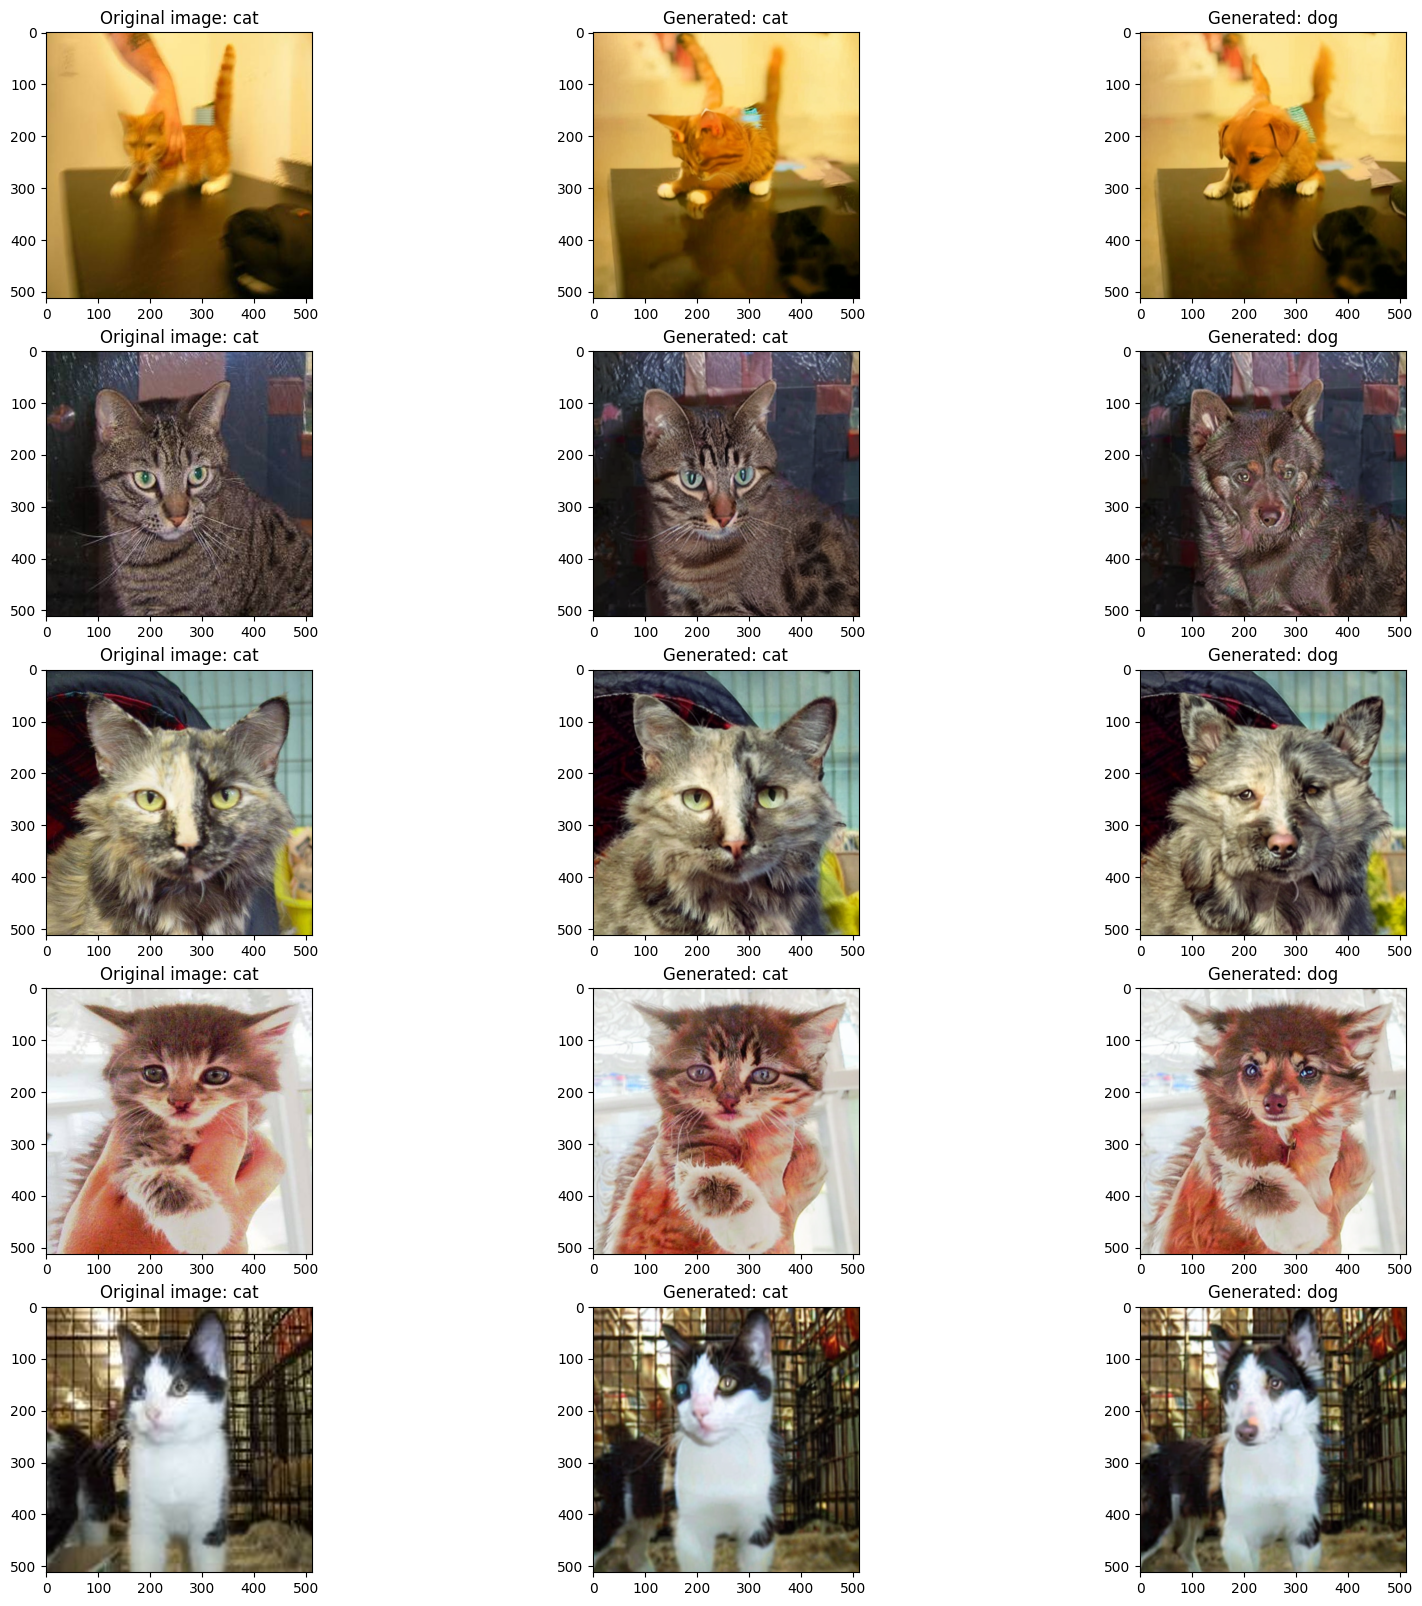

In [46]:
# Plot some correct predictions for latent_loss

image_count = 5
correct = {k:v for k,v in results_dict.items() if v['label'] == v['predictions']['latent_loss']}
correct = list(correct.items())
correct = correct[:image_count]

fig, axs = plt.subplots(len(correct), 3, figsize=(20, 20))
for i, (k,v) in enumerate(correct):
    axs[i, 0].imshow(v['images']['original'])
    axs[i, 0].set_title(f'Original image: {labels[v["label"]]}')
    axs[i, 1].imshow(v['images']['label_0'])
    axs[i, 1].set_title(f'Generated: {labels[0]}')
    axs[i, 2].imshow(v['images']['label_1'])
    axs[i, 2].set_title(f'Generated: {labels[1]}')






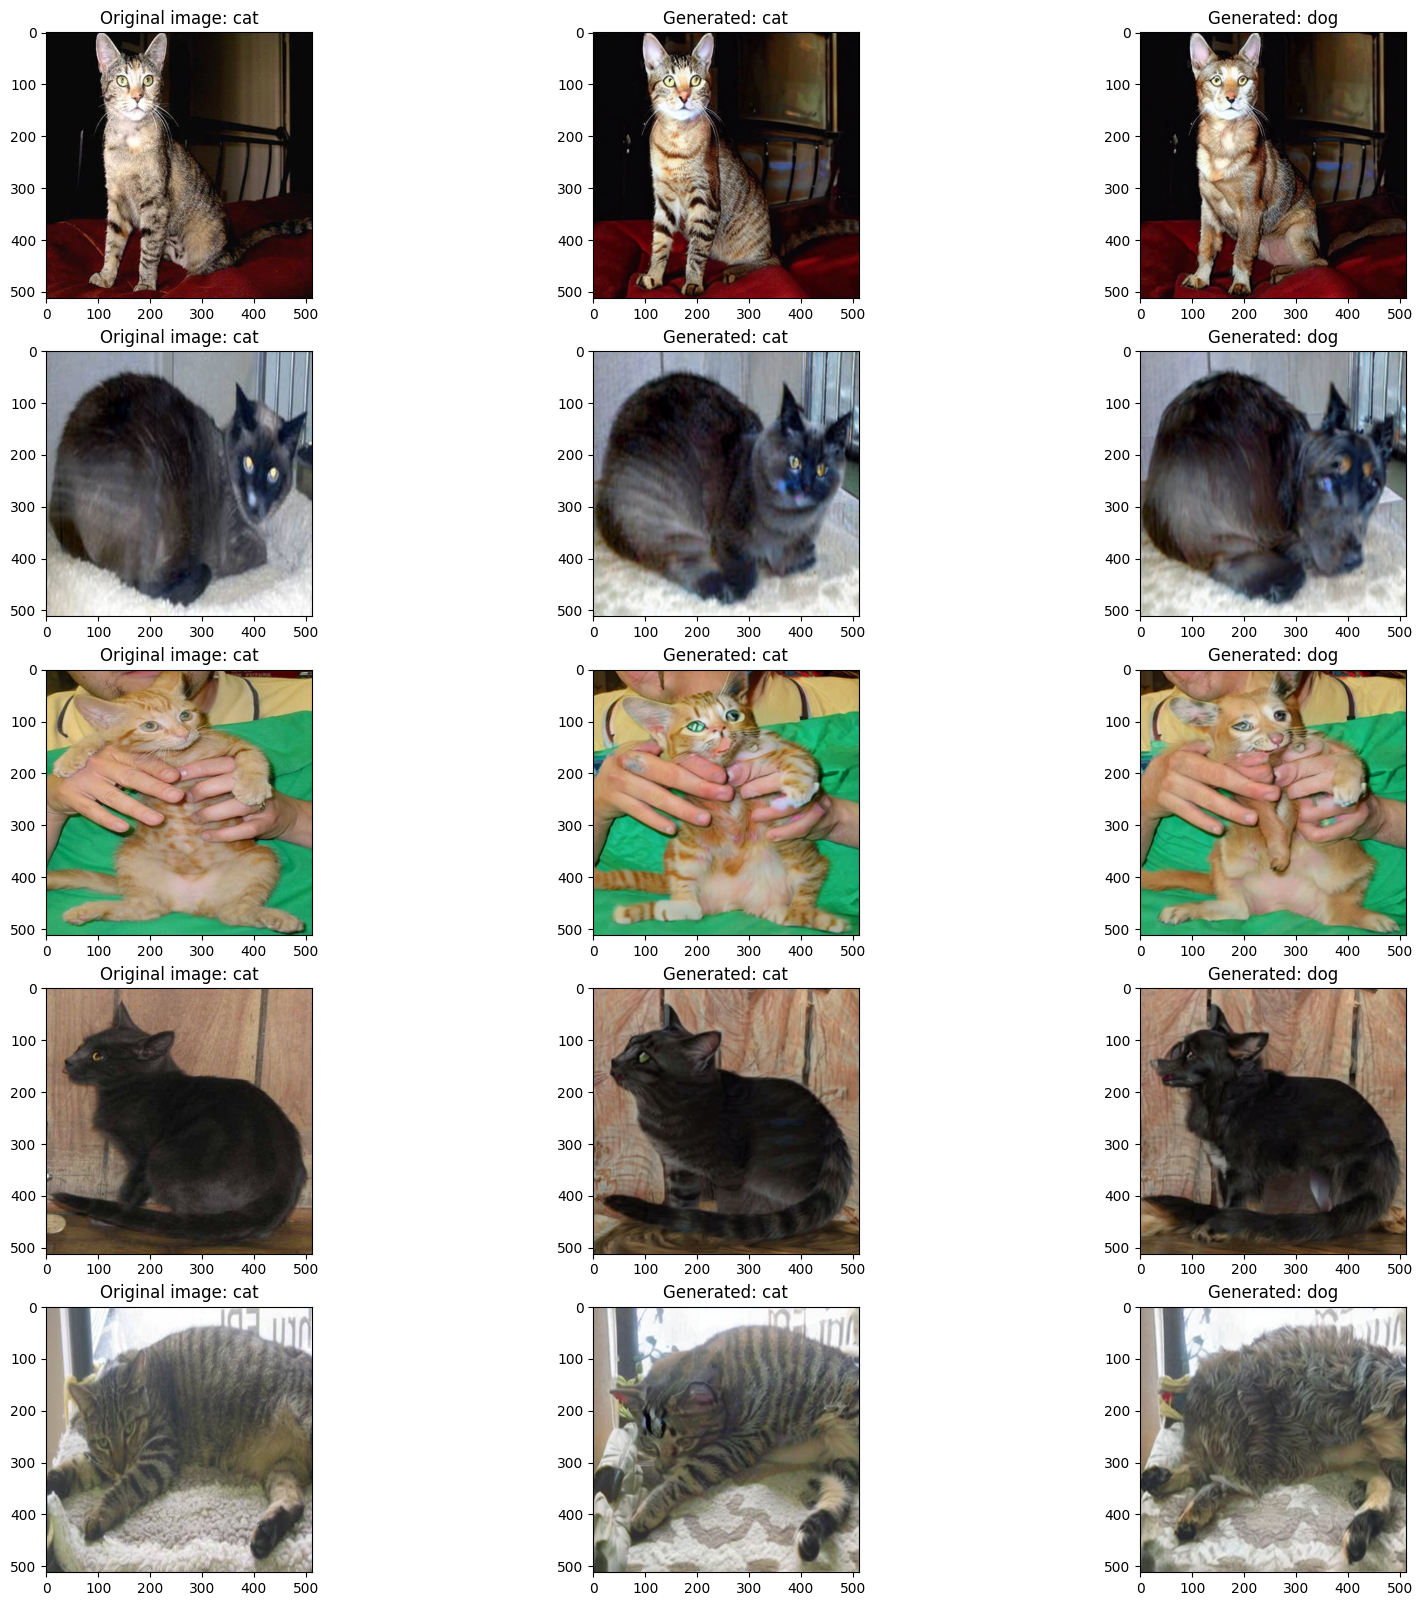

In [47]:
# plot some incorrect predictions for latent_loss

image_count = 5
incorrect = {k:v for k,v in results_dict.items() if v['label'] != v['predictions']['latent_loss']}
incorrect = list(incorrect.items())
incorrect = incorrect[:image_count]

fig, axs = plt.subplots(len(incorrect), 3, figsize=(20, 20), squeeze=False)
for i, (k,v) in enumerate(incorrect):
    axs[i, 0].imshow(v['images']['original'])
    axs[i, 0].set_title(f'Original image: {labels[v["label"]]}')
    axs[i, 1].imshow(v['images']['label_0'])
    axs[i, 1].set_title(f'Generated: {labels[0]}')
    axs[i, 2].imshow(v['images']['label_1'])
    axs[i, 2].set_title(f'Generated: {labels[1]}')